# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=pnl['Price in USDT']-pnl['Book Cost']
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(3)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,2394.894885,1.000,-131.886217,2.099598e+02,78.073632
BTCUSDT,601.021649,704.734418,0.294,3.537078,1.037128e+02,107.249847
OMUSDT,526.319895,689.065799,0.288,0.000000,1.627459e+02,162.745904
SOLUSDT,281.200518,371.051428,0.155,0.000000,8.985091e+01,89.850910
JASMYUSDT,387.458505,287.584433,0.120,0.000000,-9.987407e+01,-99.874072
ETHUSDT,250.747339,221.931789,0.093,0.000000,-2.881555e+01,-28.815550
TRXUSDT,76.868953,80.671544,0.034,-10.723889,3.802591e+00,-6.921298
BBUSDT,60.176053,38.765261,0.016,-39.733101,-2.141079e+01,-61.143893
BNBUSDT,1.142121,1.090211,0.000,-10.606040,-5.190990e-02,-10.657950
PEPEUSDT,0.000004,0.000003,0.000,-38.521986,-7.331592e-07,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities_history.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities_history[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23   -378.365173
2024-09-24   -354.861834
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
2024-09-28   -264.557571
2024-09-29   -274.041199
2024-09-30   -341.995647
2024-10-01   -407.161268
2024-10-02   -413.261248
2024-10-03   -418.872086
2024-10-04   -341.823654
2024-10-05   -356.743174
2024-10-06   -322.367398
2024-10-07   -337.500769
2024-10-08   -344.180408
2024-10-09   -375.615395
2024-10-10   -347.926055
2024-10-11   -302.956679
2024-10-12   -276.666978
2024-10-13   -265.907701
2024-10-14   -142.332259
2024-10-15   -163.448396
2024-10-16   -168.424332
2024-10-17   -183.334771
2024-10-18   -176.385224
2024-10-19   -180.957063
2024-10-20   -143.937680
2024-10-21   -186.314601
2024-10-22   -201.935715
2024-10-23   -250.904729
2024-10-24   -234.108305
2024-10-25   -339.306249
2024-10-26   -322.303981
2024-10-27   -200.301397
2024-10-28   -222.114486
2024-10-29   -159.909168
2024-10-30   -155.100477
2024-10-31   -224.945662
2024-11-01   -224.730511


In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

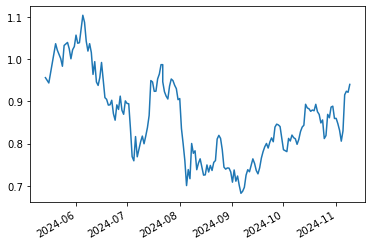

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT', 'RAYUSDT', 'RUNEUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'WLDUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.001},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3318
TRXUSDT,0.2762
BNBUSDT,0.2179
RAYUSDT,0.0588
PEPEUSDT,0.0573
SUIUSDT,0.0561
FDUSDUSDT,0.0010
USDCUSDT,0.0010
DYDXUSDT,0.0000
BONKUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.398187
BTCUSDT,0.300000
BNBUSDT,0.117701
RAYUSDT,0.067140
SUIUSDT,0.053398
PEPEUSDT,0.047297
TRXUSDT,0.016277


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.758852
OMUSDT,0.241148


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,704.734418,0.294265,0.000000,0.000000
OMUSDT,689.065799,0.287723,0.241148,0.046575
SOLUSDT,371.051428,0.154934,0.000000,0.000000
JASMYUSDT,287.584433,0.120082,0.000000,0.000000
ETHUSDT,221.931789,0.092669,0.000000,0.000000
TRXUSDT,80.671544,0.033685,0.758852,-0.725167
BBUSDT,38.765261,0.016187,0.000000,0.000000
BNBUSDT,1.090211,0.000455,0.000000,0.000000
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,704.734418,0.294265,0.300000,-0.005735
OMUSDT,689.065799,0.287723,0.398187,-0.110464
SOLUSDT,371.051428,0.154934,0.000000,0.000000
JASMYUSDT,287.584433,0.120082,0.000000,0.000000
ETHUSDT,221.931789,0.092669,0.000000,0.000000
TRXUSDT,80.671544,0.033685,0.016277,0.017408
BBUSDT,38.765261,0.016187,0.000000,0.000000
BNBUSDT,1.090211,0.000455,0.117701,-0.117246
PEPEUSDT,0.000003,0.000000,0.047297,-0.047297
RAYUSDT,0.000000,0.000000,0.067140,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

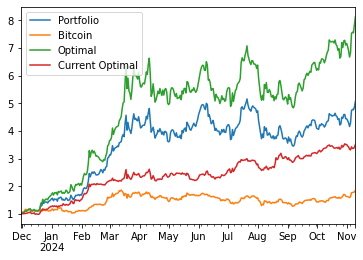

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

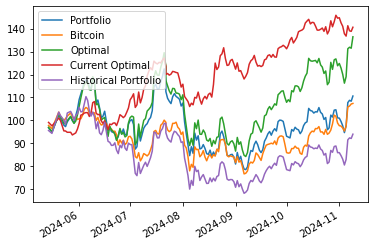

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-10-31,101.085488,98.842997,123.813665,144.539540,85.953443
2024-11-01,101.006698,97.717294,124.814006,144.724539,85.974244
2024-11-02,99.562347,97.546629,122.856768,142.554934,84.703394
2024-11-03,97.687321,96.701083,120.100650,141.007091,83.138049
2024-11-04,94.692866,95.390284,116.228605,137.737667,80.587176
2024-11-05,97.643453,97.506416,119.040079,136.724557,83.011146
2024-11-06,107.773289,105.853184,131.217314,141.241754,91.545394
2024-11-07,108.760119,106.252886,131.876073,139.026922,92.392868
2024-11-08,108.378529,107.162077,131.452228,138.804458,92.145309
2024-11-09,110.624370,107.396678,136.432611,140.583569,94.008988


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.643218
 dtype: float64,
 0.644122826260944)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.523906
 dtype: float64,
 0.523906262115016)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.584140
Bitcoin            0.432923
Optimal            0.644123
Current Optimal    0.388364
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2402231410436212

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.166542,0.117701,0.025036,0.044111,0.007483,0.036628
BTCUSDT,0.257083,0.300000,0.049067,0.135688,0.040656,0.095032
OMUSDT,9.389357,0.398187,0.862067,0.670201,0.548600,0.121601
PEPEUSDT,0.144412,0.047297,0.016885,0.045272,0.008439,0.036834
RAYUSDT,0.297774,0.067140,0.032141,0.069590,0.015260,0.054330
SUIUSDT,0.089987,0.053398,0.012629,0.032867,0.006427,0.026440
TRXUSDT,0.008424,0.016277,0.002176,0.002271,0.000053,0.002218


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.160903,0.241148,0.291717,0.457816,0.396480,0.061336
TRXUSDT,0.217318,0.758852,0.708283,0.542184,0.480848,0.061336


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.056927,0.292929,0.275889,0.193123,0.050940,0.142183
OMUSDT,0.195453,0.292929,0.385128,0.366018,0.203535,0.162482
SOLUSDT,0.032195,0.151515,0.144870,0.154770,0.034800,0.119970
JASMYUSDT,-0.011339,0.121212,0.086644,0.173998,0.046373,0.127625
ETHUSDT,-0.001830,0.090909,0.070246,0.074164,0.008737,0.065428
TRXUSDT,0.008678,0.030303,0.030740,0.004401,0.000267,0.004134
BBUSDT,-0.011980,0.020202,0.006484,0.033527,0.002553,0.030974


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.053499274866449745, -0.0766311725489269)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04998623177656205, -0.06636206520481526)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012507
OMUSDT      -0.018743
SOLUSDT     -0.004521
JASMYUSDT   -0.006559
ETHUSDT     -0.006984
TRXUSDT      0.000217
BBUSDT      -0.000889
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049986
Name: 2024-08-04 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.012703
OMUSDT      -0.021807
SOLUSDT     -0.010932
JASMYUSDT   -0.011450
ETHUSDT     -0.005401
TRXUSDT     -0.000493
BBUSDT      -0.001940
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.064724
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06674145591756522, -0.08554409349574427)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.054285091712803775, -0.06957847857920307)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.060243418432772214, -0.07700105860036578)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05252255047812819, -0.06678164758665356)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.009719
OMUSDT      -0.019726
SOLUSDT     -0.008492
JASMYUSDT   -0.008716
ETHUSDT     -0.003789
TRXUSDT      0.000112
BBUSDT      -0.001874
Portfolio   -0.052203
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06059920745599093, -0.07693103459700745)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05343785875262428, -0.06626493041970198)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010243
OMUSDT      -0.017977
SOLUSDT     -0.008577
JASMYUSDT   -0.009392
ETHUSDT     -0.003989
TRXUSDT     -0.000214
BBUSDT      -0.001691
Portfolio   -0.052083
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06106353956563193, -0.07866464068022251)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05278831700870223, -0.06768602378534029)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.010630
OMUSDT      -0.019668
SOLUSDT     -0.008203
JASMYUSDT   -0.008690
ETHUSDT     -0.004166
TRXUSDT     -0.000137
BBUSDT      -0.001811
Portfolio   -0.053305
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10857130224198691, -0.15272263673284914)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06536456647989222, -0.08933704411890715)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.009746
OMUSDT      -0.044349
SOLUSDT     -0.004706
JASMYUSDT   -0.004588
ETHUSDT     -0.001882
TRXUSDT      0.000276
BBUSDT      -0.000930
Portfolio   -0.065925
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0684433443134417, -0.0856615893086662)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055103950942502436, -0.06862328736610725)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.010593
OMUSDT      -0.020195
SOLUSDT     -0.008738
JASMYUSDT   -0.009245
ETHUSDT     -0.004145
TRXUSDT     -0.000201
BBUSDT      -0.002036
Portfolio   -0.055154
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.060752,-0.105359,-0.088196,-0.020837
2024-01-15,-0.060752,-0.105359,-0.088786,0.020116
2024-01-16,-0.060752,-0.104824,-0.087699,0.046685
2024-01-17,-0.060752,-0.106160,-0.084801,-0.021486
2024-01-18,-0.060752,-0.108671,-0.094504,-0.037849
...,...,...,...,...
2024-11-06,-0.044244,-0.072930,-0.068467,0.102295
2024-11-07,-0.044244,-0.072825,-0.068828,0.005020
2024-11-08,-0.044244,-0.072259,-0.065200,-0.003214
2024-11-09,-0.044244,-0.073470,-0.067000,0.037887


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031624,-0.085236,-0.077987,-0.016931
2024-05-29,-0.028169,-0.082344,-0.075600,-0.010146
2024-05-30,-0.028169,-0.070741,-0.063666,0.033086
2024-05-31,-0.028169,-0.069776,-0.061421,0.026202
2024-06-01,-0.028169,-0.070835,-0.062688,0.040930
...,...,...,...,...
2024-11-06,-0.050182,-0.091987,-0.087516,0.103743
2024-11-07,-0.050182,-0.090360,-0.085244,0.009157
2024-11-08,-0.050182,-0.090520,-0.085486,-0.003509
2024-11-09,-0.033489,-0.082735,-0.072059,0.020722


<AxesSubplot:>

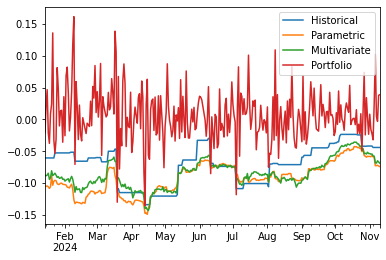

In [79]:
var_data.plot()

<AxesSubplot:>

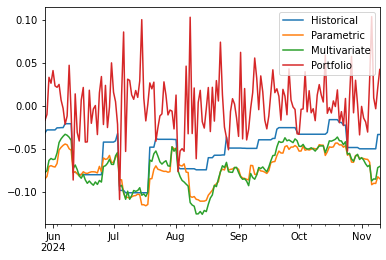

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.023179,0.009934,0.013245
Kupiec Stat,5.663579,15.006796,11.996816
P-value,0.017321,0.000107,0.000533


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.071856,0.017964,0.017964
Kupiec Stat,1.488108,4.736523,4.736523
P-value,0.22251,0.029529,0.029529


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.79994626, 0.06412446, 0.05196451, 0.04348773, 0.04047704])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.014799
ADAUSDT      0.014760
ALGOUSDT     0.015697
APEUSDT      0.017744
APTUSDT      0.015418
               ...   
WBETHUSDT    0.012153
WBTCUSDT     0.009838
WLDUSDT      0.021733
XLMUSDT      0.009394
XRPUSDT      0.009167
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

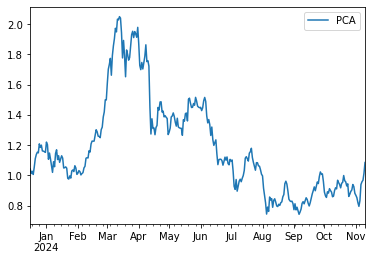

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

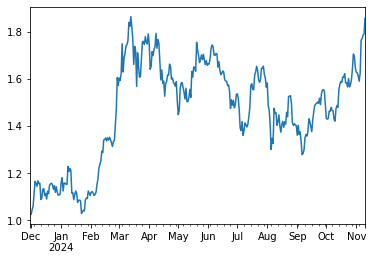

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ALGOUSDT     0.366603
ETHUSDT      0.371344
WBETHUSDT    0.371479
FLOWUSDT     0.376966
               ...   
RAYUSDT      1.009248
PEPEUSDT     1.021561
FLOKIUSDT    1.029052
WLDUSDT      1.075559
OMUSDT       1.338806
Length: 65, dtype: float64

<AxesSubplot:>

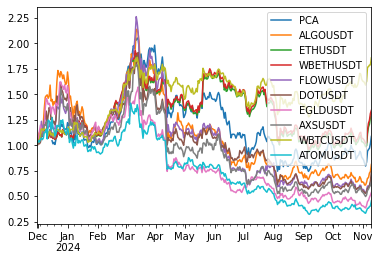

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

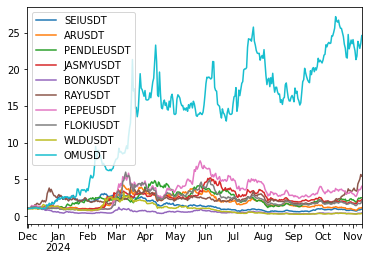

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.68627273, 0.1299704 , 0.08866275, 0.06418922, 0.0309049 ])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.066129
OMUSDT       0.096120
SOLUSDT      0.106070
JASMYUSDT    0.157563
ETHUSDT      0.089731
TRXUSDT      0.014066
BBUSDT       0.230908
BNBUSDT      0.067376
PEPEUSDT     0.172037
Name: PC1, dtype: float64

<AxesSubplot:>

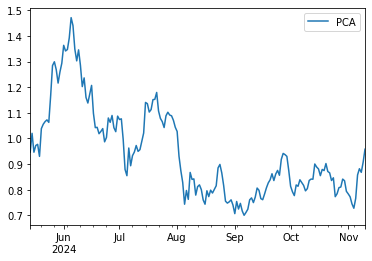

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

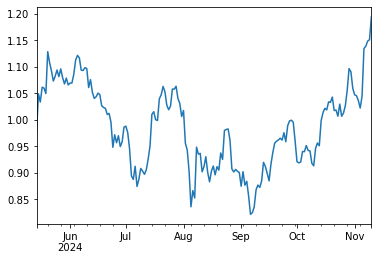

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.347927
SOLUSDT      0.358474
BTCUSDT      0.386888
BNBUSDT      0.393313
JASMYUSDT    0.435076
PEPEUSDT     0.493933
OMUSDT       0.590346
TRXUSDT      0.594820
BBUSDT       0.653219
dtype: float64

<AxesSubplot:>

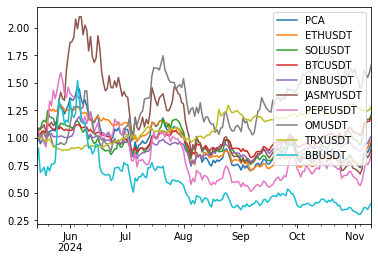

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.946894
BBUSDT       1.636250
JASMYUSDT    1.333474
SOLUSDT      1.172253
BTCUSDT      1.000000
ETHUSDT      0.972585
OMUSDT       0.955489
BNBUSDT      0.675425
TRXUSDT      0.267665
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    1.933400
PEPEUSDT     1.758095
BBUSDT       1.506299
SOLUSDT      1.194678
ETHUSDT      1.135139
BTCUSDT      1.000000
OMUSDT       0.905409
BNBUSDT      0.644109
TRXUSDT      0.226003
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,OMUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.000000,0.625881,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.000000,0.182521,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.414537,0.133222,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926689,0.000000,0.073311,0.000000
2024-09-02,0.000000,0.435173,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.287486,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.000000,0.176595,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [99]:
results={}
window=14
days=90
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APEUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,...,TIAUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT
2024-08-26,0.366473,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.268670,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-09-09,0.198648,0.0,0.0,0.800057,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-09-23,0.330709,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.016043,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.342319
2024-10-07,0.011968,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.338107,0.000000,0.0,0.0,0.0,0.0,0.034671,0.000000,0.000000
2024-10-21,0.011968,0.0,0.0,0.019429,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.476962,0.056828,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-11-04,0.011968,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.064325,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-11-10,0.011968,0.0,0.0,0.000000,0.0,0.0,0.009191,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.259441,0.000000


In [100]:
rolling_optimization.iloc[-3].sort_values(ascending=False)

TRXUSDT     0.476962
DOGEUSDT    0.268360
LTCUSDT     0.076705
UNIUSDT     0.056828
OMUSDT      0.049546
              ...   
GALAUSDT    0.000000
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
XRPUSDT     0.000000
Name: 2024-10-21 00:00:00, Length: 64, dtype: float64

<AxesSubplot:>

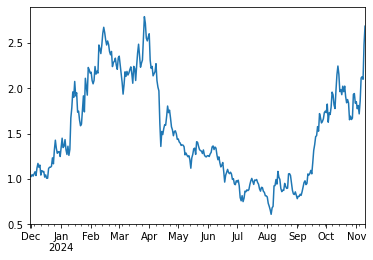

In [101]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()